## Instrucciones generales 

1. Forme un grupo de **máximo tres estudiantes**
1. Versione su trabajo usando un **repositorio <font color="red">privado</font> de github**. Agregue a sus compañeros y a su profesor (usuario github: phuijse) en la pestaña *Settings/Manage access*. No se aceptarán consultas si la tarea no está en github. No se evaluarán tareas que no estén en github.
1. Se evaluará el **resultado, la profundidad de su análisis y la calidad/orden de sus códigos** en base al último commit antes de la fecha y hora de entrega". Se bonificará a quienes muestren un método de trabajo incremental y ordenado según el histórico de *commits*
1. Sean honestos, ríganse por el [código de ética de la ACM](https://www.acm.org/about-acm/code-of-ethics-in-spanish)

# Mi primera Red Neuronal Bayesiana

Las redes neuronales son modelos del estado del arte para hacer regresión y clasificación con datos complejos

Generalmente estos modelos requieren de una gran cantidad de datos para poder entrenarlos de forma efectiva y sin que se sobreajusten. Sin embargo, en algunos problemas los datos disponibles son simplemente muy escasos o muy difíciles de obtener. Adicionalmente, no es directo tomar decisiones en base al modelo, y se requiere un paso adicional de calibración. ¿Cómo podemos confiar en las decisiones del modelo?

Podemos intentar solucionar estos problemas escribiendo la red neuronal como un modelo bayesiano y aprender el posterior de sus parámetros con un método de Markov Chain Monte Carlo (siempre y cuando el modelo sea simple). 

Incorporando priors el modelo estará regularizado y en lugar de estimadores puntuales tendremos la distribución a posteriori completa. Esta rica información extra nos permite medir la confianza del modelo sobre sus predicciones (el modelo sabe cuando no sabe) facilitando la tarea de calibración. 



## Formulación clásica

En esta tarea se pide que programen un modelo de red neuronal para clasificación de datos bidimensionales, de dos clases, con una capa oculta y con función de activación sigmoidal

Sea el conjunto de datos y etiquetas

$$
\mathcal{D} = \{(x, y)^{(i)}, i=1,2,\ldots,N\} \quad x^{(i)} \in \mathbb{R}^2,  y^{(i)} \in \{0, 1\}
$$

Consideremos ahora una tupla en particular $(X, Y)$. La salida de la capa oculta en notación matricial es

$$
Z = \text{sigmoide}( W_Z X + B_Z)
$$

donde $W_Z \in \mathbb{R}^{M \times 2}$, $B_Z \in \mathbb{R}^{M}$ y  $M$ es el tamaño de la capa oculta

La salida de la capa visible (última capa) en notación matricial es

$$
Y = \text{sigmoide}( W_Y Z + B_Y)
$$

donde $W_Y \in \mathbb{R}^{1 \times M}$, $B_Z \in \mathbb{R}$

La función sigmoide se define como

$$
\text{sigmoide}(x) = \frac{1}{1+ e^{-x}}
$$

Luego $Z$ es un vector de largo $M$ con valores en $[0, 1]$ e $Y$ es un escalar con valor en el rango $[0, 1]$

## Formulación bayesiana

Para darle un toque bayesiano a este modelo debemos

- Definir priors para $W_Z$, $B_Z$, $W_Y$ y $B_Y$. Se pide que utilice priors **normales con media cero y desviación estándar diez**.
- Definir una verosimilitud para le problema. Dado que el problema es de clasificación binaria, utilice una distribución de **Bernoulli** con $p=Y$
- Considere los datos $X$ como una variable determínista. 

## Indicaciones

Utilice

- El atributo `shape` para darle la dimensión correcta a cada variable cada uno
- El atributo `observed` para asignar las etiquetas reales a esta variable aleatoria observada
- `pm.Data` para la variable independiente
- `theano.tensor.sigmoid` para calcular la función sigmoide
- `A.dot(B)` para calcular el producto matricial entre `A` y `B`



## Instrucciones específicas

- Considere el dataset sintético `two-moons` que se muestra a continuación. Se pide que realice dos experimentos variando el valor de `n_samples`, primero a $100$ y finalmente a $10$
- Implemente el modelo de red neuronal bayesiana en `pymc3` dejando $M$ como un argumento. Para cada valor de `n_samples` entrene tres modelos con $M=1$, $M=3$ y $M=10$
- Seleccione y calibre un algoritmo de MCMC para entrenar este modelo. Justifique y respalde sus decisiones en base al comportamiento de las trazas, al estadístico Gelman-Rubin y a la función de autocorrelación
- Estudie el posterior de los parámetros y evalue el posterior predictivo sobre los datos de prueba. Muestre graficamente la media y la varianza del posterior predictivo en el espacio de los datos. Haga observaciones y comparaciones entre los 6 casos (3 valores de $M$ y 2 valores de `n_samples`)

# Solución

In [1]:
import pymc3 as pm
import theano
from theano.tensor.nnet import sigmoid

## Implementación del modelo (n_samples = 100)

<IPython.core.display.Javascript object>


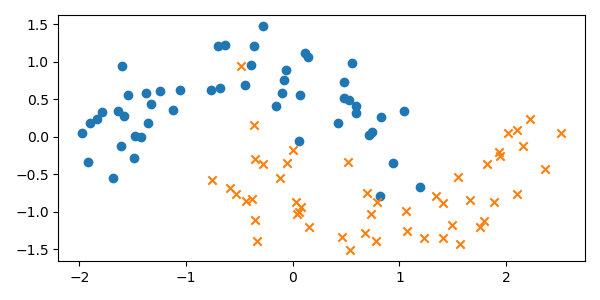

In [153]:
%matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import make_moons

x, y = make_moons(n_samples=100, # Varie este parámetro
                  shuffle=True, noise=0.2, random_state=123456)
x = (x - np.mean(x, keepdims=True))/np.std(x, keepdims=True)

fig, ax = plt.subplots(figsize=(6, 3), tight_layout=True)
ax.scatter(x[y==0, 0], x[y==0, 1], marker='o')
ax.scatter(x[y==1, 0], x[y==1, 1], marker='x')

x1100, x2100 = np.meshgrid(np.linspace(-3, 3, 100), 
                     np.linspace(-3, 3, 100))
x_test100 = np.vstack([x1100.ravel(), x2100.ravel()]).T

In [34]:
def modelrnb(M):
    with pm.Model() as bayes_reg:
        #datos de entrada
        X_shared = pm.Data("x", x).T
        Y_shared = pm.Data("y", y)
        #prioris
        wz = pm.Normal(name='wz', mu=0, sd =10, shape=(M,2))
        bz = pm.Normal(name='bz', mu=0, sd =10, shape=(M,1))
        wy = pm.Normal(name='wy', mu=0, sd =10, shape=(1,M))
        by = pm.Normal(name='by', mu=0, sd =10, shape=(1,1))
        #variable determinista 
        X = pm.Deterministic('X', X_shared)  
        Z = pm.Deterministic('Z', sigmoid(wz.dot(X)+bz))
        Y = pm.Deterministic('Y', sigmoid(wy.dot(Z)+by))
        #verosimilitud
        Y_obs = pm.Bernoulli('Y_obs', p=Y, observed=Y_shared)
    return bayes_reg

### Modelo 1 (M = 1)

In [83]:
a100 = modelrnb(1)
a100

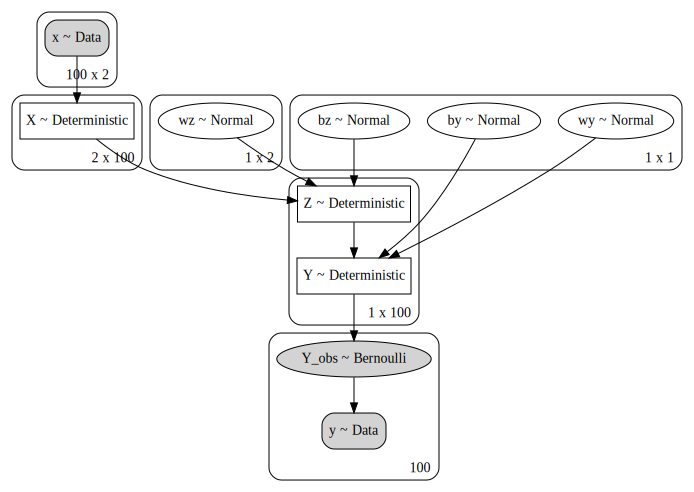

In [84]:
pm.model_to_graphviz(a100)

### Modelo 2 (M = 3)

In [37]:
b100 = modelrnb(3)
b100

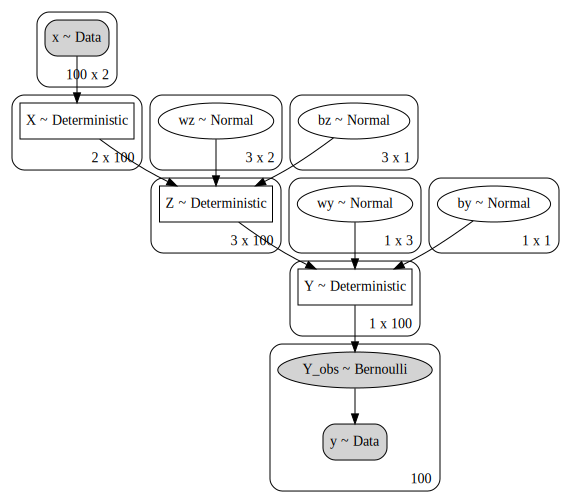

In [38]:
pm.model_to_graphviz(b100)

### Modelo 3 (M = 10)

In [157]:
c100 = modelrnb(10)
c100

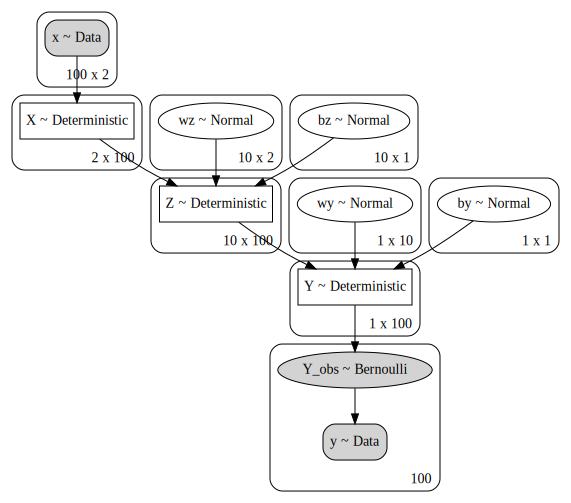

In [40]:
pm.model_to_graphviz(c100)

## Implementación del modelo (n_samples = 10)

<IPython.core.display.Javascript object>


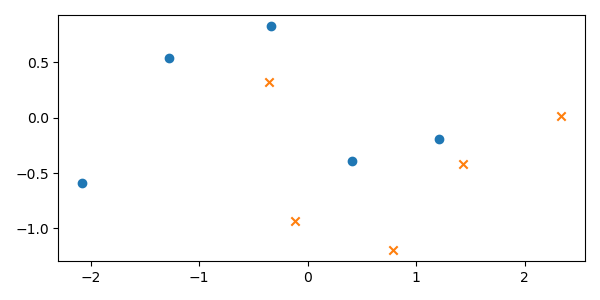

In [97]:
%matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import make_moons

x, y = make_moons(n_samples=10, # Varie este parámetro
                  shuffle=True, noise=0.2, random_state=123456)
x = (x - np.mean(x, keepdims=True))/np.std(x, keepdims=True)

fig, ax = plt.subplots(figsize=(6, 3), tight_layout=True)
ax.scatter(x[y==0, 0], x[y==0, 1], marker='o')
ax.scatter(x[y==1, 0], x[y==1, 1], marker='x')

x110, x210 = np.meshgrid(np.linspace(-3, 3, 100), 
                     np.linspace(-3, 3, 100))
x_test10 = np.vstack([x110.ravel(), x210.ravel()]).T

### Modelo 1 (M = 1)

In [98]:
a10 = modelrnb(1)
a10

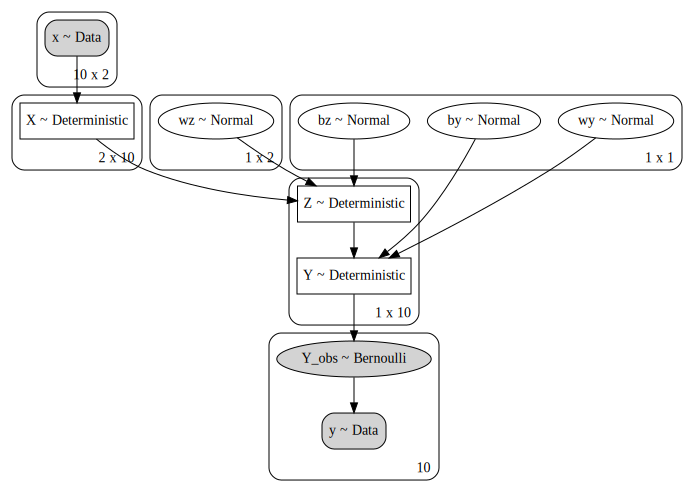

In [99]:
pm.model_to_graphviz(a10)

### Modelo 2 (M = 3)

In [100]:
b10 = modelrnb(3)
b10

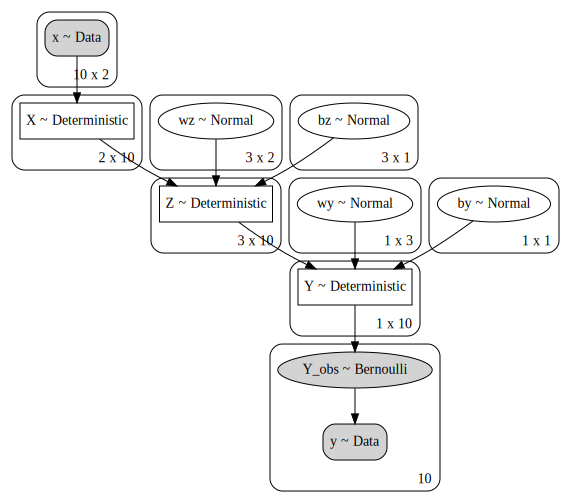

In [101]:
pm.model_to_graphviz(b10)

### Modelo 3 (M = 10)

In [102]:
c10 = modelrnb(10)
c10

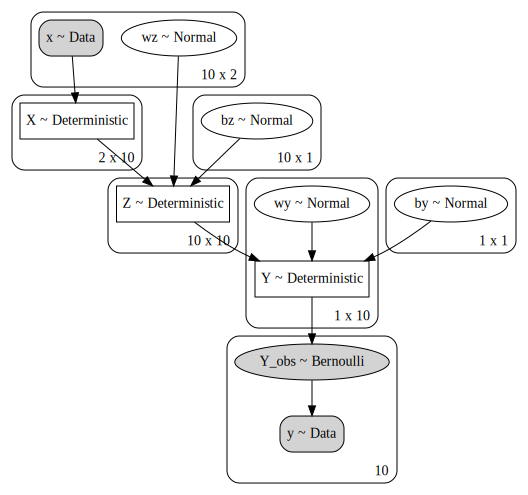

In [103]:
pm.model_to_graphviz(c10)

## Selección y calibración de un algoritmo de MCMC para entrenar este modelo.

In [155]:
%matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import make_moons

x, y = make_moons(n_samples=100, # Varie este parámetro
                  shuffle=True, noise=0.2, random_state=123456)
x = (x - np.mean(x, keepdims=True))/np.std(x, keepdims=True)

x1100, x2100 = np.meshgrid(np.linspace(-3, 3, 100), 
                     np.linspace(-3, 3, 100))
x_test100 = np.vstack([x1100.ravel(), x2100.ravel()]).T

### Modelo 1 (100 samples)

#### Entrenamiento Algoritmo MCMC

In [86]:
with a100:
    trace_m1 = pm.sample(draws=3500,
                      tune=500,
                      chains=2,
                      cores=4,
                      step=pm.NUTS())


Multiprocess sampling (2 chains in 4 jobs)
NUTS: [by, wy, bz, wz]
Sampling 2 chains, 5 divergences: 100%|████████████████████████████████████████| 8000/8000 [00:12<00:00, 620.16draws/s]
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.


####  Trazas

<IPython.core.display.Javascript object>


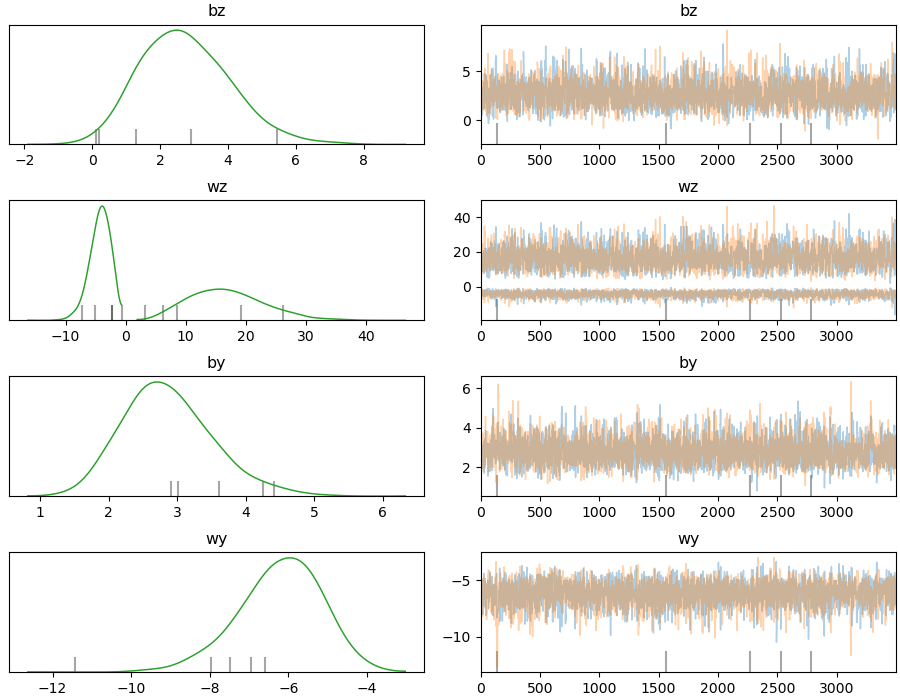

C:\Users\spun\miniconda3\lib\site-packages\arviz\plots\backends\matplotlib\distplot.py:36: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  warnings.warn(
C:\Users\spun\miniconda3\lib\site-packages\arviz\plots\backends\matplotlib\distplot.py:36: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  warnings.warn(
C:\Users\spun\miniconda3\lib\site-packages\arviz\plots\backends\matplotlib\distplot.py:36: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  warnings.warn(
C:\Users\spun\miniconda3\lib\site-packages\arviz\plots\backends\matplotlib\distplot.py:36: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  warnings.warn(
C:\Users\spun\miniconda3\lib\site-packages\arviz\plots\backends\matplotlib\distplot.py:36: UserWarning: Argument backend_kwargs has not effect in matplo

In [87]:
pm.traceplot(trace_m1, figsize=(9, 7), var_names=['bz', 'wz', 'by','wy'], combined=True);

#### Valor de $\hat{r}$

In [88]:
pm.summary(trace_m1, var_names=['bz', 'wz', 'by','wy']).round(3)

mean     sd  hpd_3%  hpd_97%  mcse_mean  mcse_sd  ess_mean  ess_sd  \
bz[0,0]   2.722  1.312   0.281    5.100      0.029    0.020    2100.0  2100.0   
wz[0,0]  -4.336  1.738  -7.307   -1.169      0.041    0.030    1775.0  1685.0   
wz[0,1]  16.803  6.228   5.690   27.894      0.143    0.101    1888.0  1888.0   
by[0,0]   2.859  0.656   1.698    4.117      0.014    0.010    2330.0  2183.0   
wy[0,0]  -6.246  1.059  -8.190   -4.247      0.022    0.016    2296.0  2099.0   

         ess_bulk  ess_tail  r_hat  
bz[0,0]    2086.0    3051.0    1.0  
wz[0,0]    1823.0    2571.0    1.0  
wz[0,1]    1894.0    2865.0    1.0  
by[0,0]    2471.0    2628.0    1.0  
wy[0,0]    2506.0    2283.0    1.0

#### Autocorrelación

<IPython.core.display.Javascript object>


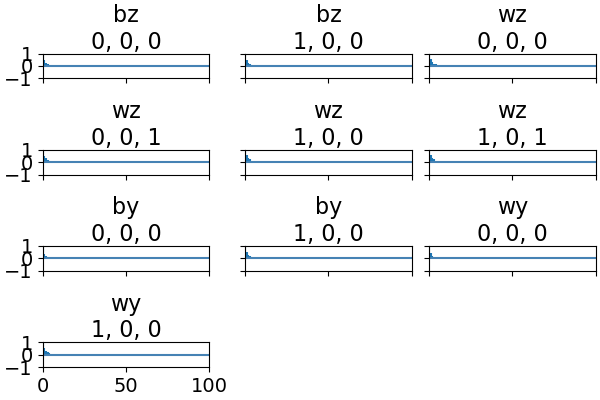

In [89]:
pm.plots.autocorrplot(trace_m1, figsize=(6, 4), 
                      var_names=['bz', 'wz', 'by','wy']);

### Modelo 2 (100 samples)

####  Entrenamiento Algoritmo MCMC

In [72]:
with b100:
    trace_m2 = pm.sample(draws=5000,
                      tune=1000,
                      chains=2,
                      cores=4,
                      step=pm.NUTS())

Multiprocess sampling (2 chains in 4 jobs)
NUTS: [by, wy, bz, wz]
Sampling 2 chains, 6 divergences: 100%|███████████████████████████████████████| 12000/12000 [02:11<00:00, 91.44draws/s]
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.2 for some parameters.
The estimated number of effective samples is smaller than 200 for some parameters.


#### Trazas

<IPython.core.display.Javascript object>


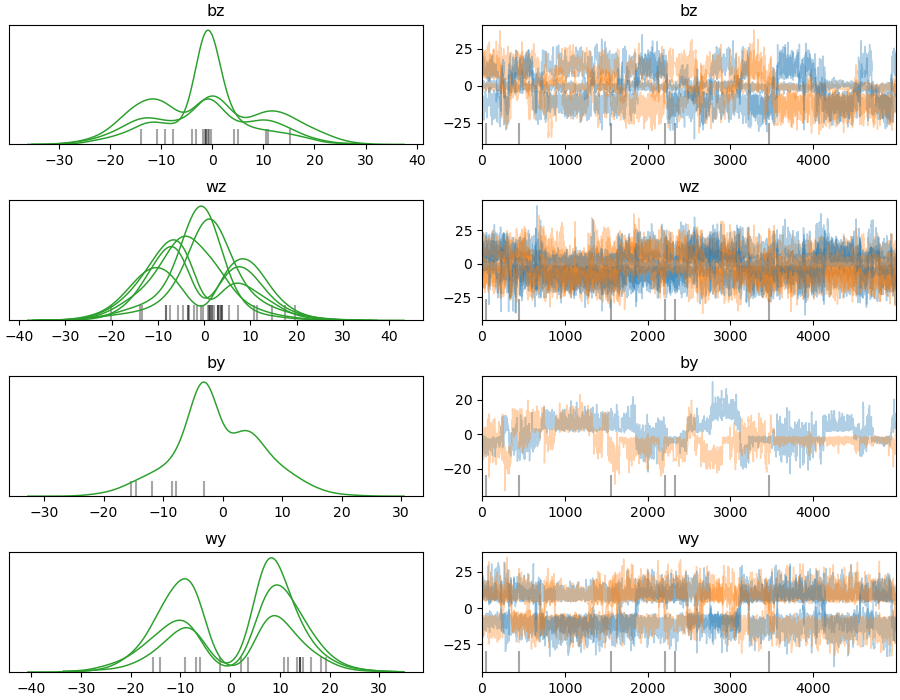

C:\Users\spun\miniconda3\lib\site-packages\arviz\plots\backends\matplotlib\distplot.py:36: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  warnings.warn(
C:\Users\spun\miniconda3\lib\site-packages\arviz\plots\backends\matplotlib\distplot.py:36: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  warnings.warn(
C:\Users\spun\miniconda3\lib\site-packages\arviz\plots\backends\matplotlib\distplot.py:36: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  warnings.warn(
C:\Users\spun\miniconda3\lib\site-packages\arviz\plots\backends\matplotlib\distplot.py:36: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  warnings.warn(
C:\Users\spun\miniconda3\lib\site-packages\arviz\plots\backends\matplotlib\distplot.py:36: UserWarning: Argument backend_kwargs has not effect in matplo

In [73]:
pm.traceplot(trace_m2, figsize=(9, 7), var_names=['bz', 'wz', 'by','wy'], combined=True);

#### Valor de $\hat{r}$

In [74]:
pm.summary(trace_m2, var_names=['bz', 'wz', 'by','wy']).round(3)

mean      sd  hpd_3%  hpd_97%  mcse_mean  mcse_sd  ess_mean  ess_sd  \
bz[0,0]  1.065  11.806 -20.250   21.427      3.624    2.636      11.0    11.0   
bz[1,0] -1.251   8.310 -18.858   15.932      1.216    1.133      47.0    27.0   
bz[2,0] -3.475  10.968 -21.017   17.309      1.613    1.148      46.0    46.0   
wz[0,0] -0.782  10.066 -17.155   17.056      3.403    2.491       9.0     9.0   
wz[0,1]  1.124   7.930 -15.065   18.456      2.007    1.446      16.0    16.0   
wz[1,0] -3.303   9.930 -19.606   15.957      1.876    1.341      28.0    28.0   
wz[1,1] -3.505   8.026 -19.477   11.833      2.676    1.958       9.0     9.0   
wz[2,0] -0.556  11.689 -19.624   18.357      2.595    1.862      20.0    20.0   
wz[2,1] -1.777   6.817 -17.545   10.001      1.132    0.807      36.0    36.0   
by[0,0] -0.762   7.212 -14.720   13.154      1.376    0.984      27.0    27.0   
wy[0,0] -2.980  11.511 -20.778   17.271      4.869    3.641       6.0     6.0   
wy[0,1]  3.661  10.651 -16.501   20.370      4.349    3.238       6.0     6.0   
wy[0,2]  1.781  12.618 -21.503   19.657      3.972    2.894      10.0    10.0   

         ess_bulk  ess_tail  r_hat  
bz[0,0]      11.0      63.0   1.14  
bz[1,0]      50.0      40.0   1.11  
bz[2,0]      53.0     314.0   1.02  
wz[0,0]      11.0     328.0   1.13  
wz[0,1]      13.0      57.0   1.14  
wz[1,0]      36.0     232.0   1.04  
wz[1,1]       8.0     114.0   1.19  
wz[2,0]      26.0     506.0   1.08  
wz[2,1]      28.0     149.0   1.08  
by[0,0]      28.0      94.0   1.07  
wy[0,0]       8.0      54.0   1.21  
wy[0,1]       8.0      42.0   1.20  
wy[0,2]      12.0      96.0   1.15

#### Autocorrelación

<IPython.core.display.Javascript object>


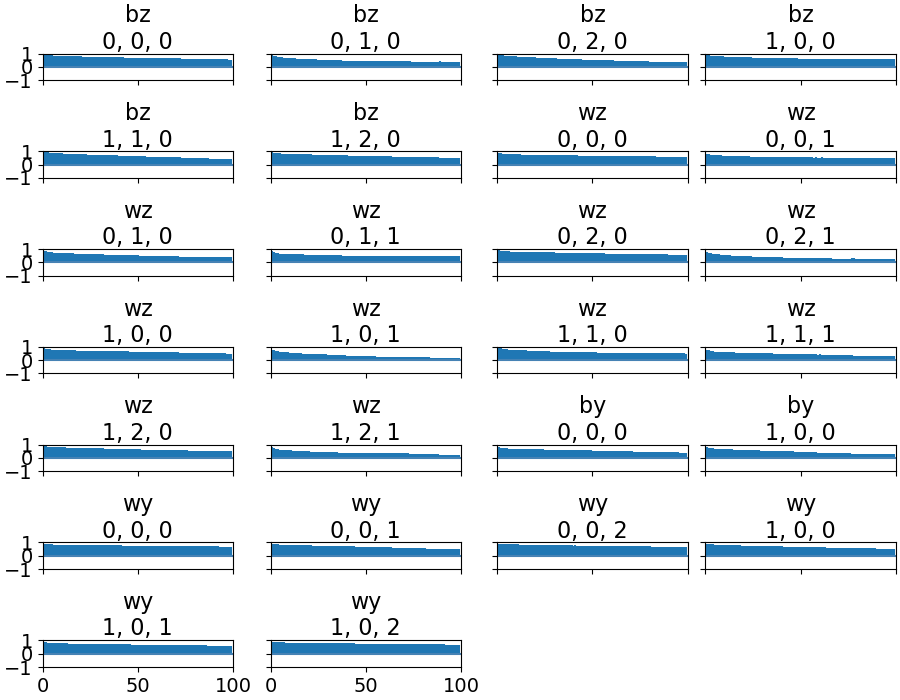

In [75]:
pm.plots.autocorrplot(trace_m2, figsize=(9, 7), 
                      var_names=['bz', 'wz', 'by','wy']);

### Modelo 3 (100 samples)

#### Entrenamiento Algoritmo MCMC

In [158]:
with c100:
    trace_m3 = pm.sample(draws=1500,
                      tune=500,
                      chains=2,
                      cores=4,
                      step=pm.NUTS())

Multiprocess sampling (2 chains in 4 jobs)
NUTS: [by, wy, bz, wz]
Sampling 2 chains, 0 divergences: 100%|█████████████████████████████████████████| 4000/4000 [02:02<00:00, 32.73draws/s]
The number of effective samples is smaller than 25% for some parameters.


#### Trazas 

<IPython.core.display.Javascript object>


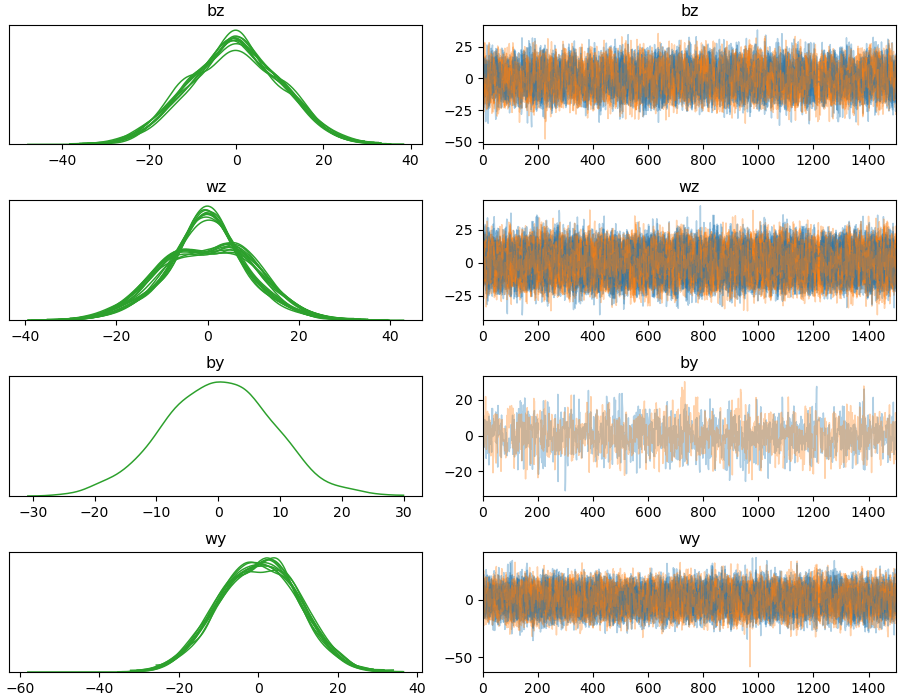

C:\Users\spun\miniconda3\lib\site-packages\arviz\plots\backends\matplotlib\distplot.py:36: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  warnings.warn(
C:\Users\spun\miniconda3\lib\site-packages\arviz\plots\backends\matplotlib\distplot.py:36: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  warnings.warn(
C:\Users\spun\miniconda3\lib\site-packages\arviz\plots\backends\matplotlib\distplot.py:36: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  warnings.warn(
C:\Users\spun\miniconda3\lib\site-packages\arviz\plots\backends\matplotlib\distplot.py:36: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  warnings.warn(
C:\Users\spun\miniconda3\lib\site-packages\arviz\plots\backends\matplotlib\distplot.py:36: UserWarning: Argument backend_kwargs has not effect in matplo

In [159]:
pm.traceplot(trace_m3, figsize=(9, 7), var_names=['bz', 'wz', 'by','wy'], combined=True);

#### Valor de $\hat{r}$

In [160]:
pm.summary(trace_m3, var_names=['bz', 'wz', 'by','wy']).round(3)

mean      sd  hpd_3%  hpd_97%  mcse_mean  mcse_sd  ess_mean  ess_sd  \
bz[0,0] -0.126  10.375 -20.836   17.636      0.450    0.319     531.0   531.0   
bz[1,0]  0.029  10.430 -20.082   18.656      0.442    0.313     556.0   556.0   
bz[2,0] -0.577  10.613 -21.465   18.128      0.479    0.339     491.0   491.0   
bz[3,0] -0.526  10.968 -20.137   18.965      0.483    0.341     516.0   516.0   
bz[4,0] -0.045  10.573 -20.810   18.509      0.421    0.298     630.0   630.0   
bz[5,0] -0.651  10.446 -19.644   19.303      0.423    0.299     610.0   610.0   
bz[6,0]  0.260  10.119 -19.194   18.494      0.424    0.300     569.0   569.0   
bz[7,0] -0.705  10.387 -20.792   17.683      0.427    0.302     591.0   591.0   
bz[8,0]  0.042  10.447 -19.680   18.994      0.453    0.320     532.0   532.0   
bz[9,0] -0.463  10.568 -19.644   19.558      0.452    0.320     547.0   547.0   
wz[0,0] -0.282  10.688 -19.958   19.566      0.403    0.285     703.0   703.0   
wz[0,1] -0.238   8.926 -17.341   18.207      0.311    0.220     822.0   822.0   
wz[1,0] -0.148  10.761 -19.083   19.717      0.406    0.287     702.0   702.0   
wz[1,1]  0.060   8.834 -18.506   16.346      0.288    0.204     943.0   940.0   
wz[2,0] -0.501  10.304 -20.271   17.479      0.370    0.261     778.0   778.0   
wz[2,1]  0.144   9.050 -17.191   17.481      0.292    0.207     958.0   958.0   
wz[3,0]  0.539  10.396 -17.689   19.562      0.385    0.273     727.0   727.0   
wz[3,1]  0.015   8.720 -15.744   18.108      0.264    0.187    1090.0  1090.0   
wz[4,0] -0.258  10.434 -18.657   19.722      0.390    0.276     716.0   716.0   
wz[4,1] -0.118   8.849 -17.401   16.585      0.288    0.204     941.0   941.0   
wz[5,0]  0.183  10.413 -19.739   18.216      0.389    0.275     716.0   716.0   
wz[5,1] -0.544   8.963 -18.890   16.101      0.291    0.206     952.0   952.0   
wz[6,0] -0.141  10.369 -17.495   20.377      0.424    0.300     598.0   598.0   
wz[6,1] -0.016   8.707 -16.242   17.746      0.266    0.188    1071.0  1071.0   
wz[7,0]  0.800  10.235 -17.947   19.754      0.408    0.289     629.0   629.0   
wz[7,1] -0.055   9.181 -18.233   17.428      0.351    0.248     685.0   685.0   
wz[8,0]  0.246  10.013 -18.519   18.096      0.360    0.255     772.0   772.0   
wz[8,1] -0.169   9.152 -20.020   16.518      0.328    0.232     781.0   781.0   
wz[9,0]  0.411  10.361 -19.360   18.354      0.381    0.270     738.0   738.0   
wz[9,1] -0.188   8.528 -15.819   18.014      0.269    0.190    1007.0  1007.0   
by[0,0]  0.035   8.693 -16.629   16.026      0.228    0.162    1449.0  1449.0   
wy[0,0] -0.005   9.727 -18.429   17.472      0.414    0.293     552.0   552.0   
wy[0,1]  0.174   9.694 -17.689   17.908      0.404    0.286     576.0   576.0   
wy[0,2] -0.152   9.912 -19.069   17.206      0.366    0.259     732.0   732.0   
wy[0,3]  0.393   9.926 -18.425   17.873      0.379    0.268     685.0   685.0   
wy[0,4] -0.252   9.917 -19.431   17.636      0.374    0.265     703.0   703.0   
wy[0,5]  0.290   9.676 -18.011   17.643      0.373    0.264     674.0   674.0   
wy[0,6] -0.297   9.923 -19.089   17.800      0.414    0.293     575.0   575.0   
wy[0,7]  0.910   9.785 -16.649   20.223      0.388    0.275     635.0   635.0   
wy[0,8]  0.192  10.084 -18.595   19.781      0.409    0.290     607.0   607.0   
wy[0,9]  0.692   9.979 -17.221   19.407      0.425    0.301     551.0   551.0   

         ess_bulk  ess_tail  r_hat  
bz[0,0]     528.0    1266.0   1.00  
bz[1,0]     558.0    1340.0   1.00  
bz[2,0]     494.0    1259.0   1.01  
bz[3,0]     533.0    1479.0   1.00  
bz[4,0]     639.0    1209.0   1.00  
bz[5,0]     616.0    1384.0   1.00  
bz[6,0]     571.0    1290.0   1.00  
bz[7,0]     598.0    1610.0   1.01  
bz[8,0]     545.0    1524.0   1.00  
bz[9,0]     547.0    1286.0   1.00  
wz[0,0]     713.0    1451.0   1.00  
wz[0,1]     805.0    1298.0   1.00  
wz[1,0]     713.0    1644.0   1.00  
wz[1,1]     937.0    1435.0   1.00  
wz[2,0]     791.0    1436.0   1.00  
wz[2,1]     957

#### Autocorrelación 

C:\Users\spun\miniconda3\lib\site-packages\arviz\plots\plot_utils.py:624: SyntaxWarning: rcParams['plot.max_subplots'] (40) is smaller than the number of variables to plot (82) in plot_autocorr, generating only 40 plots
  warnings.warn(


<IPython.core.display.Javascript object>


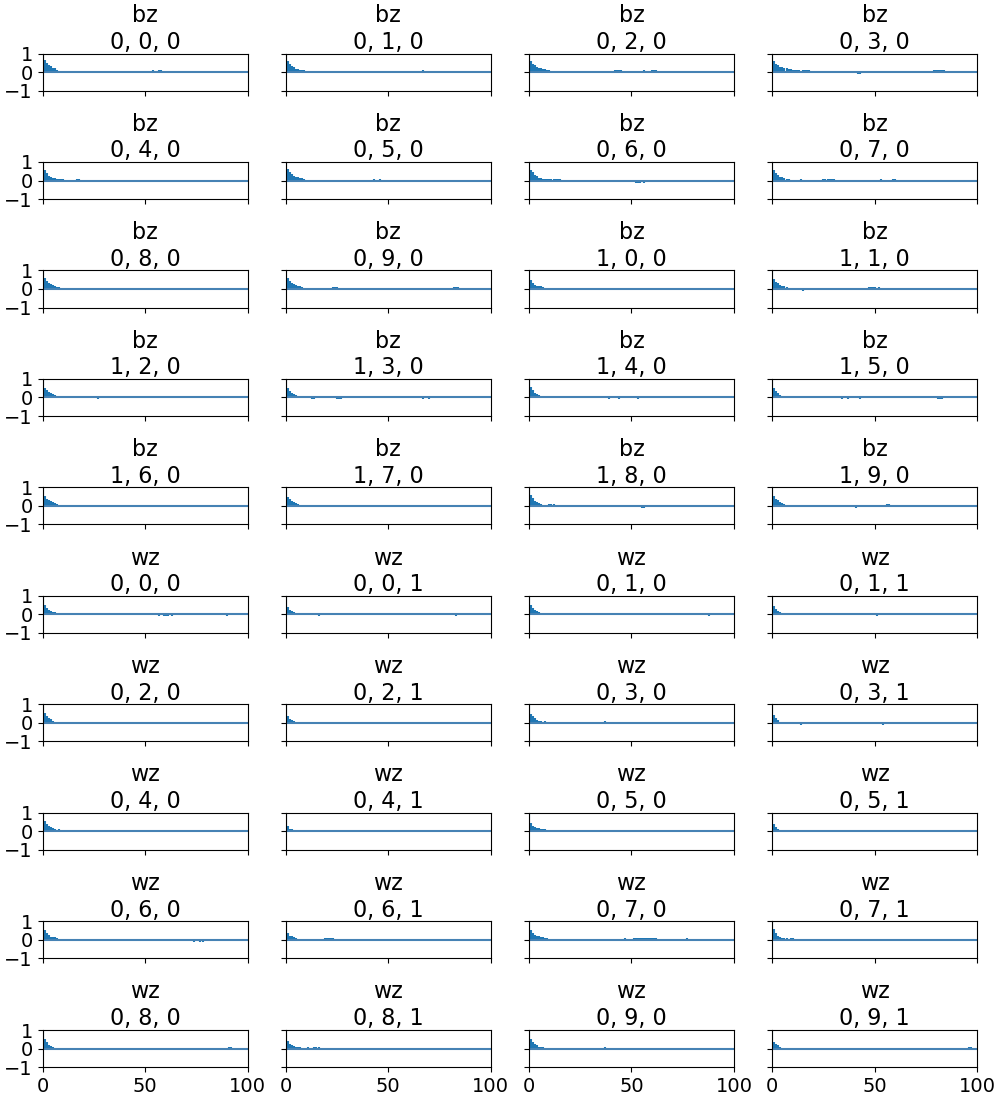

In [161]:
pm.plots.autocorrplot(trace_m3, figsize=(10, 11), 
                      var_names=['bz', 'wz', 'by','wy']);

### Modelo 4 (10 samples)

In [165]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import make_moons

x, y = make_moons(n_samples=10, # Varie este parámetro
                  shuffle=True, noise=0.2, random_state=123456)
x = (x - np.mean(x, keepdims=True))/np.std(x, keepdims=True)

x110, x210 = np.meshgrid(np.linspace(-3, 3, 100), 
                     np.linspace(-3, 3, 100))
x_test10 = np.vstack([x110.ravel(), x210.ravel()]).T

#### Entrenamiento Algoritmo MCMC

In [110]:
with a10:
    trace_m4 = pm.sample(draws=3000,
                      tune=500,
                      chains=2,
                      cores=4,
                      step=pm.NUTS())

Multiprocess sampling (2 chains in 4 jobs)
NUTS: [by, wy, bz, wz]
Sampling 2 chains, 0 divergences: 100%|████████████████████████████████████████| 7000/7000 [00:15<00:00, 439.71draws/s]
The number of effective samples is smaller than 10% for some parameters.


#### Trazas

<IPython.core.display.Javascript object>


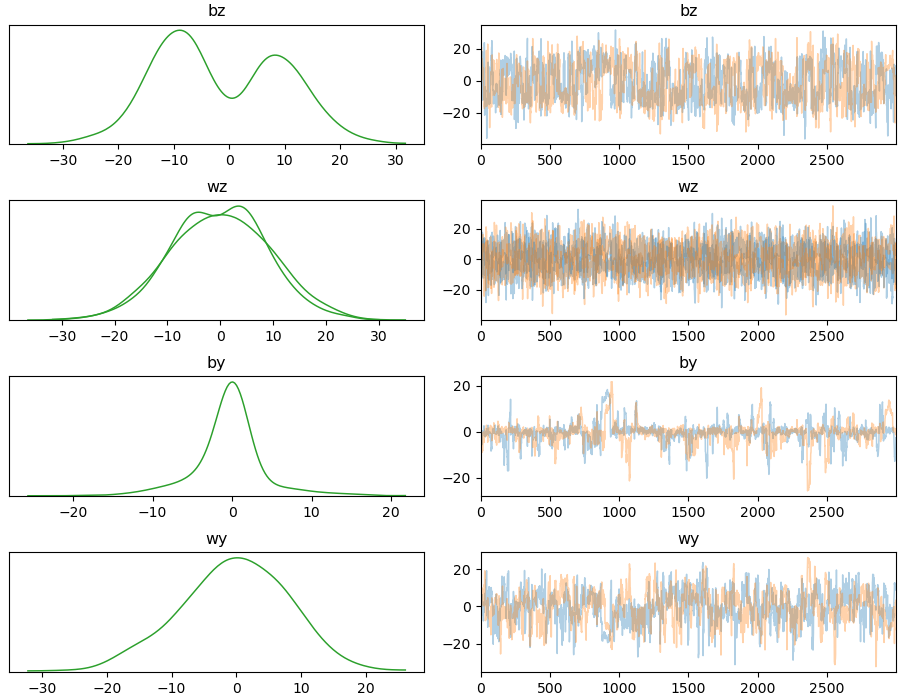

C:\Users\spun\miniconda3\lib\site-packages\arviz\plots\backends\matplotlib\distplot.py:36: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  warnings.warn(
C:\Users\spun\miniconda3\lib\site-packages\arviz\plots\backends\matplotlib\distplot.py:36: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  warnings.warn(
C:\Users\spun\miniconda3\lib\site-packages\arviz\plots\backends\matplotlib\distplot.py:36: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  warnings.warn(
C:\Users\spun\miniconda3\lib\site-packages\arviz\plots\backends\matplotlib\distplot.py:36: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  warnings.warn(
C:\Users\spun\miniconda3\lib\site-packages\arviz\plots\backends\matplotlib\distplot.py:36: UserWarning: Argument backend_kwargs has not effect in matplo

In [111]:
pm.traceplot(trace_m4, figsize=(9, 7), var_names=['bz', 'wz', 'by','wy'], combined=True);

#### Valor de $\hat{r}$

In [113]:
pm.summary(trace_m4, var_names=['bz', 'wz', 'by','wy']).round(3)

mean      sd  hpd_3%  hpd_97%  mcse_mean  mcse_sd  ess_mean  ess_sd  \
bz[0,0] -1.502  11.395 -19.857   18.671      0.587    0.415     377.0   377.0   
wz[0,0] -0.258   8.909 -17.945   15.673      0.430    0.304     430.0   430.0   
wz[0,1]  0.179   9.604 -17.886   17.837      0.414    0.293     537.0   537.0   
by[0,0] -0.404   4.647 -10.851    8.926      0.320    0.227     210.0   210.0   
wy[0,0] -0.347   8.563 -16.761   15.220      0.506    0.358     287.0   287.0   

         ess_bulk  ess_tail  r_hat  
bz[0,0]     433.0    1555.0    1.0  
wz[0,0]     433.0    1518.0    1.0  
wz[0,1]     538.0    1391.0    1.0  
by[0,0]     251.0     171.0    1.0  
wy[0,0]     286.0     610.0    1.0

#### Autocorrelacion

<IPython.core.display.Javascript object>


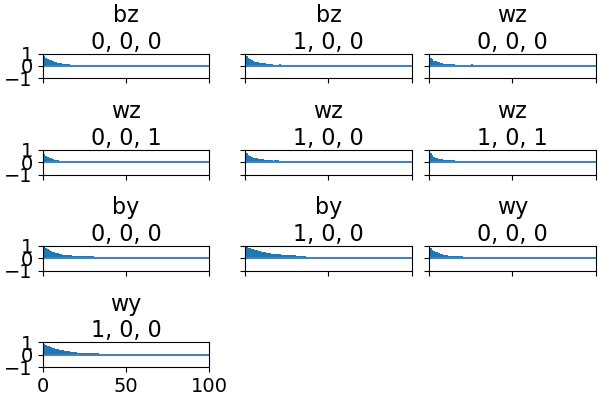

In [115]:
pm.plots.autocorrplot(trace_m4, figsize=(6, 4), 
                      var_names=['bz', 'wz', 'by','wy']);

### Modelo 5 (10 samples)

#### Entrenamiento Algoritmo MCMC

In [129]:
with b10:
    trace_m5 = pm.sample(draws=3000,
                      tune=500,
                      chains=2,
                      cores=4,
                      step=pm.NUTS())

Multiprocess sampling (2 chains in 4 jobs)
NUTS: [by, wy, bz, wz]
Sampling 2 chains, 0 divergences: 100%|████████████████████████████████████████| 7000/7000 [00:43<00:00, 160.46draws/s]
The number of effective samples is smaller than 25% for some parameters.


#### Trazas

<IPython.core.display.Javascript object>


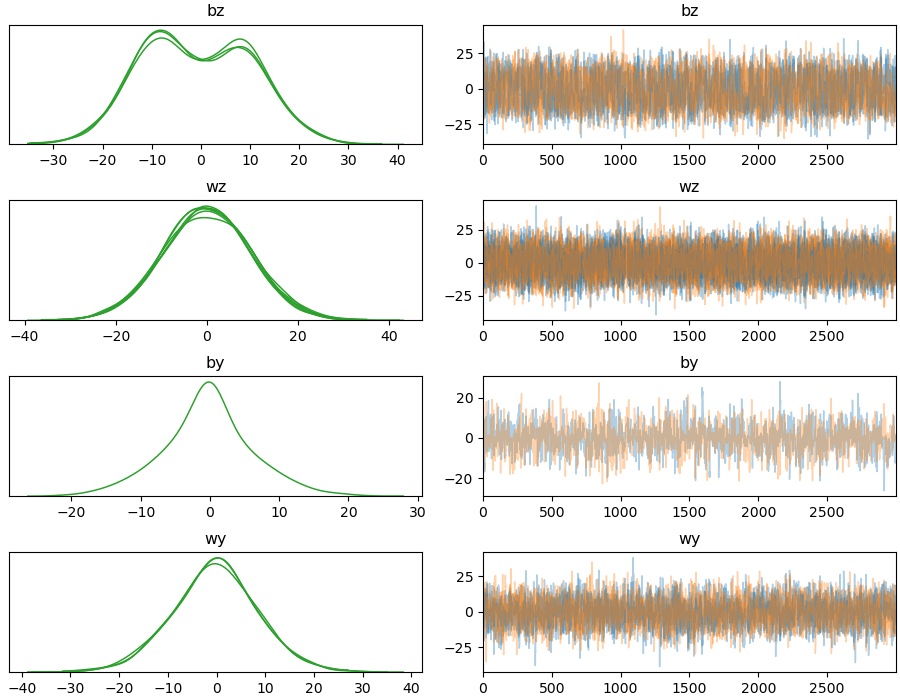

C:\Users\spun\miniconda3\lib\site-packages\arviz\plots\backends\matplotlib\distplot.py:36: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  warnings.warn(
C:\Users\spun\miniconda3\lib\site-packages\arviz\plots\backends\matplotlib\distplot.py:36: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  warnings.warn(
C:\Users\spun\miniconda3\lib\site-packages\arviz\plots\backends\matplotlib\distplot.py:36: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  warnings.warn(
C:\Users\spun\miniconda3\lib\site-packages\arviz\plots\backends\matplotlib\distplot.py:36: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  warnings.warn(
C:\Users\spun\miniconda3\lib\site-packages\arviz\plots\backends\matplotlib\distplot.py:36: UserWarning: Argument backend_kwargs has not effect in matplo

In [130]:
pm.traceplot(trace_m5, figsize=(9, 7), var_names=['bz', 'wz', 'by','wy'], combined=True);

#### Valor de $\hat{r}$

In [131]:
pm.summary(trace_m5, var_names=['bz', 'wz', 'by','wy']).round(3)

mean      sd  hpd_3%  hpd_97%  mcse_mean  mcse_sd  ess_mean  ess_sd  \
bz[0,0] -1.026  11.137 -20.141   19.301      0.338    0.239    1083.0  1083.0   
bz[1,0] -0.876  11.156 -19.760   19.096      0.356    0.252     981.0   981.0   
bz[2,0] -0.389  11.120 -20.210   19.066      0.357    0.252     972.0   972.0   
wz[0,0] -0.227   9.304 -17.405   17.723      0.251    0.178    1372.0  1372.0   
wz[0,1]  0.033   9.405 -17.923   17.558      0.225    0.159    1742.0  1742.0   
wz[1,0]  0.025   9.604 -18.187   18.649      0.264    0.187    1323.0  1323.0   
wz[1,1]  0.328   9.805 -18.714   18.442      0.228    0.161    1852.0  1852.0   
wz[2,0] -0.248   9.389 -18.525   16.512      0.260    0.184    1300.0  1300.0   
wz[2,1]  0.183   9.790 -17.682   18.558      0.257    0.182    1450.0  1450.0   
by[0,0] -0.269   6.463 -12.649   12.940      0.186    0.132    1201.0  1201.0   
wy[0,0] -0.309   8.699 -17.035   15.687      0.281    0.198     961.0   961.0   
wy[0,1] -0.204   8.654 -16.324   16.586      0.258    0.182    1125.0  1125.0   
wy[0,2] -0.269   8.497 -16.387   15.293      0.254    0.180    1118.0  1118.0   

         ess_bulk  ess_tail  r_hat  
bz[0,0]    1170.0    3540.0    1.0  
bz[1,0]    1048.0    3195.0    1.0  
bz[2,0]    1034.0    2716.0    1.0  
wz[0,0]    1366.0    2784.0    1.0  
wz[0,1]    1748.0    3318.0    1.0  
wz[1,0]    1322.0    2581.0    1.0  
wz[1,1]    1848.0    2999.0    1.0  
wz[2,0]    1285.0    2496.0    1.0  
wz[2,1]    1453.0    2280.0    1.0  
by[0,0]    1186.0    1879.0    1.0  
wy[0,0]     959.0    2107.0    1.0  
wy[0,1]    1126.0    2146.0    1.0  
wy[0,2]    1105.0    1850.0    1.0

#### Autocorrelacion

<IPython.core.display.Javascript object>


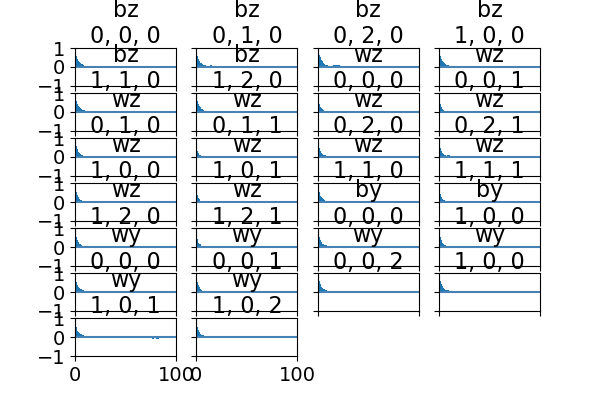

In [132]:
pm.plots.autocorrplot(trace_m5, figsize=(6, 4), 
                      var_names=['bz', 'wz', 'by','wy']);

### Modelo 6 (10 samples)

#### Entrenamiento Algoritmo MCMC

In [124]:
with c10:
    trace_m6 = pm.sample(draws=3000,
                      tune=500,
                      chains=2,
                      cores=4,
                      step=pm.NUTS())

Multiprocess sampling (2 chains in 4 jobs)
NUTS: [by, wy, bz, wz]
Sampling 2 chains, 0 divergences: 100%|█████████████████████████████████████████| 7000/7000 [01:16<00:00, 92.09draws/s]


#### Trazas

<IPython.core.display.Javascript object>


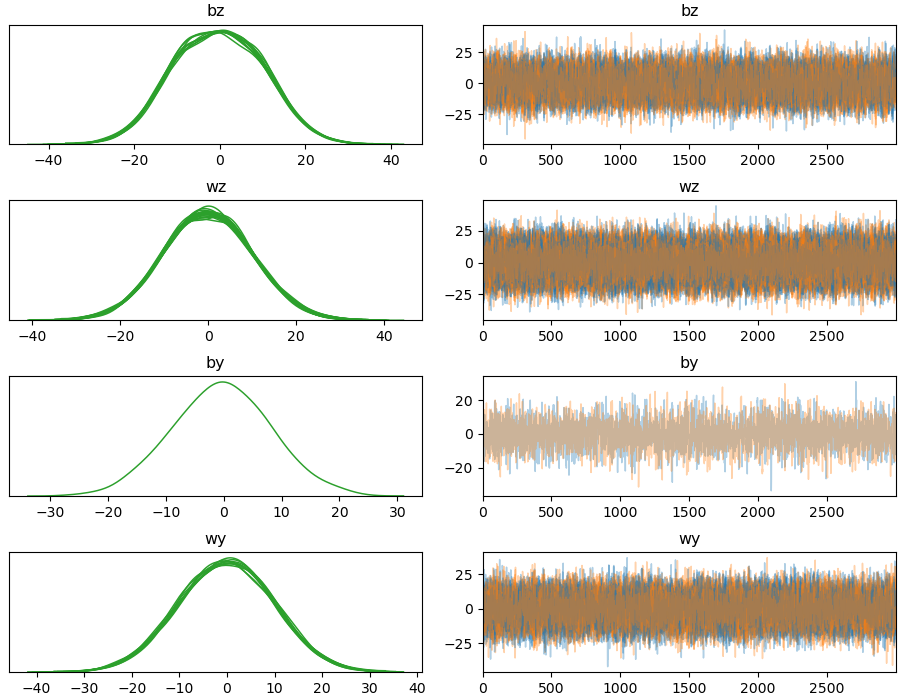

C:\Users\spun\miniconda3\lib\site-packages\arviz\plots\backends\matplotlib\distplot.py:36: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  warnings.warn(
C:\Users\spun\miniconda3\lib\site-packages\arviz\plots\backends\matplotlib\distplot.py:36: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  warnings.warn(
C:\Users\spun\miniconda3\lib\site-packages\arviz\plots\backends\matplotlib\distplot.py:36: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  warnings.warn(
C:\Users\spun\miniconda3\lib\site-packages\arviz\plots\backends\matplotlib\distplot.py:36: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  warnings.warn(
C:\Users\spun\miniconda3\lib\site-packages\arviz\plots\backends\matplotlib\distplot.py:36: UserWarning: Argument backend_kwargs has not effect in matplo

In [125]:
pm.traceplot(trace_m6, figsize=(9, 7), var_names=['bz', 'wz', 'by','wy'], combined=True);

#### Valor de $\hat{r}$

In [126]:
pm.summary(trace_m6, var_names=['bz', 'wz', 'by','wy']).round(3)

mean      sd  hpd_3%  hpd_97%  mcse_mean  mcse_sd  ess_mean  ess_sd  \
bz[0,0] -0.557  10.440 -18.259   19.721      0.220    0.156    2243.0  2243.0   
bz[1,0]  0.065  10.346 -18.029   19.705      0.226    0.160    2093.0  2093.0   
bz[2,0] -0.040  10.510 -19.612   18.532      0.230    0.162    2093.0  2093.0   
bz[3,0] -0.196  10.512 -18.667   19.698      0.228    0.161    2134.0  2134.0   
bz[4,0] -0.427  10.411 -20.065   17.637      0.237    0.168    1932.0  1932.0   
bz[5,0] -0.544  10.356 -19.258   18.672      0.230    0.163    2027.0  2027.0   
bz[6,0] -0.474  10.440 -19.231   18.904      0.239    0.169    1915.0  1915.0   
bz[7,0] -0.239  10.328 -19.652   18.160      0.229    0.162    2041.0  2041.0   
bz[8,0] -0.108  10.292 -19.537   17.921      0.259    0.183    1584.0  1584.0   
bz[9,0] -0.371  10.630 -19.937   18.848      0.273    0.193    1516.0  1516.0   
wz[0,0]  0.079  10.288 -19.130   20.047      0.203    0.144    2568.0  2568.0   
wz[0,1]  0.009   9.771 -18.156   18.146      0.156    0.127    3943.0  2968.0   
wz[1,0]  0.051   9.838 -18.407   18.459      0.203    0.144    2348.0  2348.0   
wz[1,1] -0.142  10.027 -17.199   20.191      0.165    0.129    3680.0  3001.0   
wz[2,0] -0.056  10.011 -18.310   19.207      0.203    0.144    2423.0  2423.0   
wz[2,1]  0.067   9.897 -18.296   18.390      0.165    0.122    3609.0  3296.0   
wz[3,0]  0.225  10.292 -18.088   20.424      0.203    0.144    2561.0  2561.0   
wz[3,1] -0.053   9.916 -18.705   18.173      0.160    0.120    3858.0  3434.0   
wz[4,0] -0.176  10.188 -19.412   18.627      0.235    0.167    1872.0  1872.0   
wz[4,1] -0.036   9.741 -18.593   17.576      0.155    0.117    3952.0  3495.0   
wz[5,0] -0.195  10.185 -19.090   19.141      0.197    0.139    2686.0  2667.0   
wz[5,1] -0.071   9.887 -18.256   18.445      0.164    0.121    3616.0  3349.0   
wz[6,0] -0.173  10.083 -17.637   20.065      0.213    0.151    2239.0  2239.0   
wz[6,1] -0.018   9.801 -18.266   18.435      0.169    0.120    3375.0  3315.0   
wz[7,0] -0.173  10.085 -19.163   18.205      0.204    0.144    2439.0  2439.0   
wz[7,1]  0.050   9.957 -17.892   18.936      0.162    0.120    3798.0  3424.0   
wz[8,0] -0.068   9.974 -18.583   18.968      0.205    0.145    2376.0  2376.0   
wz[8,1]  0.179   9.828 -18.363   17.967      0.164    0.130    3587.0  2845.0   
wz[9,0]  0.251  10.300 -18.501   19.733      0.222    0.157    2143.0  2143.0   
wz[9,1] -0.209   9.856 -18.169   18.363      0.166    0.122    3546.0  3285.0   
by[0,0] -0.354   8.537 -16.620   15.395      0.140    0.109    3717.0  3089.0   
wy[0,0] -0.148   9.644 -18.308   17.741      0.210    0.149    2104.0  2104.0   
wy[0,1]  0.107   9.878 -18.491   18.246      0.200    0.142    2436.0  2436.0   
wy[0,2] -0.367   9.868 -19.613   17.608      0.203    0.144    2351.0  2351.0   
wy[0,3] -0.146   9.881 -18.659   18.598      0.197    0.139    2513.0  2513.0   
wy[0,4]  0.017   9.690 -18.344   17.745      0.202    0.143    2290.0  2290.0   
wy[0,5] -0.141  10.042 -18.902   18.445      0.205    0.145    2390.0  2390.0   
wy[0,6] -0.077  10.011 -18.598   18.892      0.191    0.135    2736.0  2736.0   
wy[0,7] -0.018   9.902 -18.860   17.633      0.191    0.135    2697.0  2697.0   
wy[0,8]  0.018   9.726 -18.571   17.748      0.188    0.133    2668.0  2668.0   
wy[0,9] -0.229   9.838 -18.708   18.017      0.209    0.148    2209.0  2209.0   

         ess_bulk  ess_tail  r_hat  
bz[0,0]    2300.0    4004.0    1.0  
bz[1,0]    2137.0    3816.0    1.0  
bz[2,0]    2143.0    4111.0    1.0  
bz[3,0]    2162.0    3588.0    1.0  
bz[4,0]    1960.0    3314.0    1.0  
bz[5,0]    2067.0    3873.0    1.0  
bz[6,0]    1946.0    3775.0    1.0  
bz[7,0]    2076.0    3302.0    1.0  
bz[8,0]    1604.0    3692.0    1.0  
bz[9,0]    1537.0    3428.0    1.0  
wz[0,0]    2563.0    3712.0    1.0  
wz[0,1]    3933.0    4277.0    1.0  
wz[1,0]    2352.0    3606.0    1.0  
wz[1,1]    3678.0    3388.0    1.0  
wz[2,0]    2428.0    3907.0    1.0  
wz[2,1]    3599

#### Autocorrelacion

C:\Users\spun\miniconda3\lib\site-packages\arviz\plots\plot_utils.py:624: SyntaxWarning: rcParams['plot.max_subplots'] (40) is smaller than the number of variables to plot (82) in plot_autocorr, generating only 40 plots
  warnings.warn(


<IPython.core.display.Javascript object>


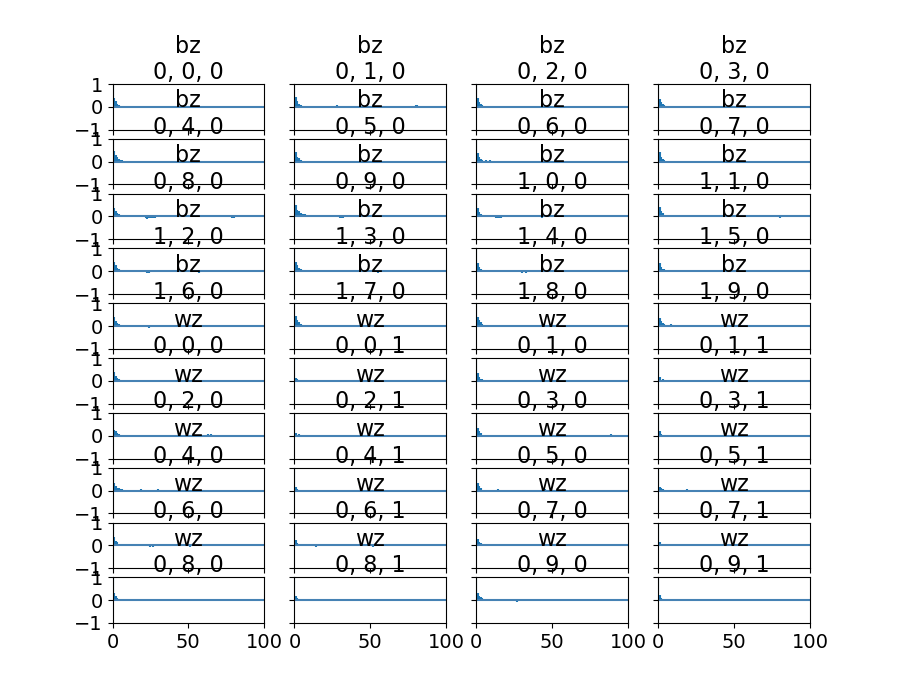

In [128]:
pm.plots.autocorrplot(trace_m6, figsize=(9, 7), 
                      var_names=['bz', 'wz', 'by','wy']);

## Observaciones

## Estudio de Posteriors

### Modelo 1 (100 samples)

In [166]:
%matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import make_moons

x, y = make_moons(n_samples=100, # Varie este parámetro
                  shuffle=True, noise=0.2, random_state=123456)
x = (x - np.mean(x, keepdims=True))/np.std(x, keepdims=True)

x1100, x2100 = np.meshgrid(np.linspace(-3, 3, 100), 
                     np.linspace(-3, 3, 100))
x_test100 = np.vstack([x1100.ravel(), x2100.ravel()]).T

#### Posterior Parámetros

<IPython.core.display.Javascript object>


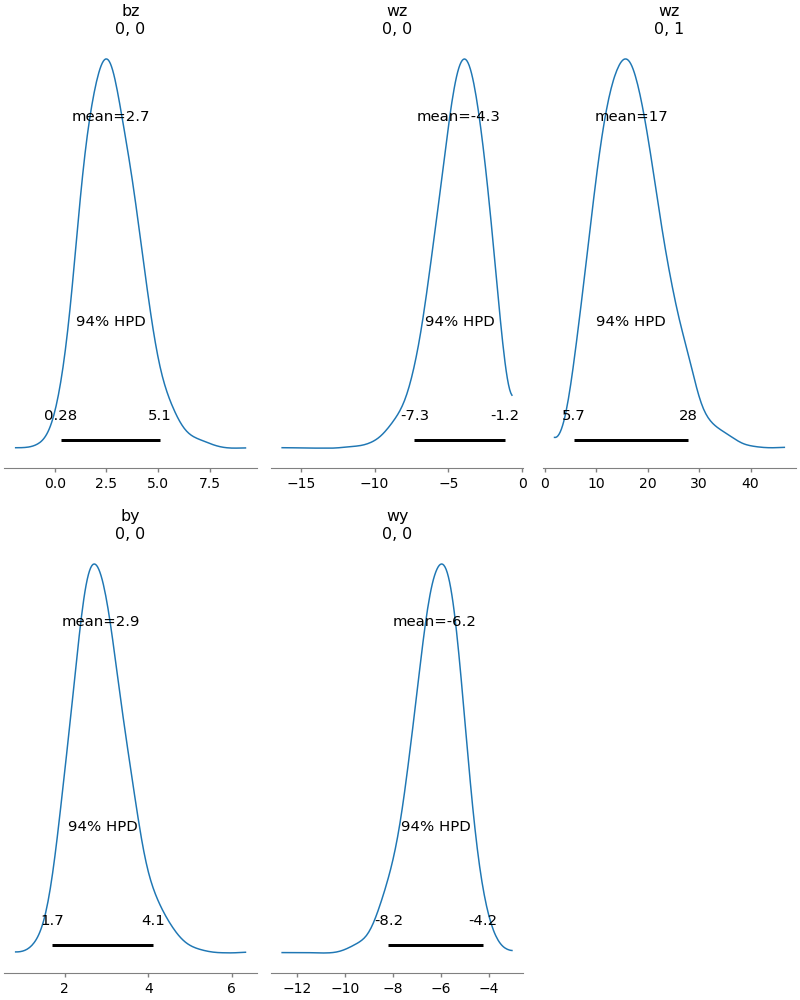

In [90]:
with a100:
    pm.plot_posterior(trace_m1, figsize=(8, 10), var_names=['bz', 'wz', 'by','wy'], textsize=10);

#### Posterior Predictiva

In [91]:
with a100:
    pm.set_data({"x": x_test100})
    posterior_predictive = pm.sample_posterior_predictive(trace_m1, samples=50, var_names=["X", "Y_obs"])

C:\Users\spun\miniconda3\lib\site-packages\pymc3\sampling.py:1246: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(
100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 69.99it/s]


<IPython.core.display.Javascript object>


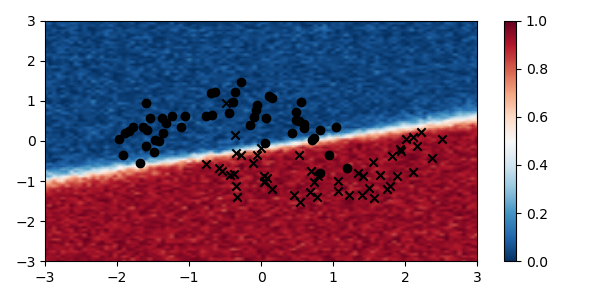

In [92]:
fig, ax = plt.subplots(figsize=(6, 3), tight_layout=True)
cmap = ax.pcolormesh(x1100, x2100, np.mean(posterior_predictive['Y_obs'], axis=0).reshape(len(x1100), len(x2100)), 
                     cmap=plt.cm.RdBu_r, shading='gouraud', vmin=0, vmax=1)
plt.colorbar(cmap, ax=ax)
ax.scatter(x[y==0, 0], x[y==0, 1], c='k', marker='o')
ax.scatter(x[y==1, 0], x[y==1, 1], c='k', marker='x')

In [55]:
len(x1100)

100

### Modelo 2 (100 samples)

#### Posterior Parámetros

<IPython.core.display.Javascript object>


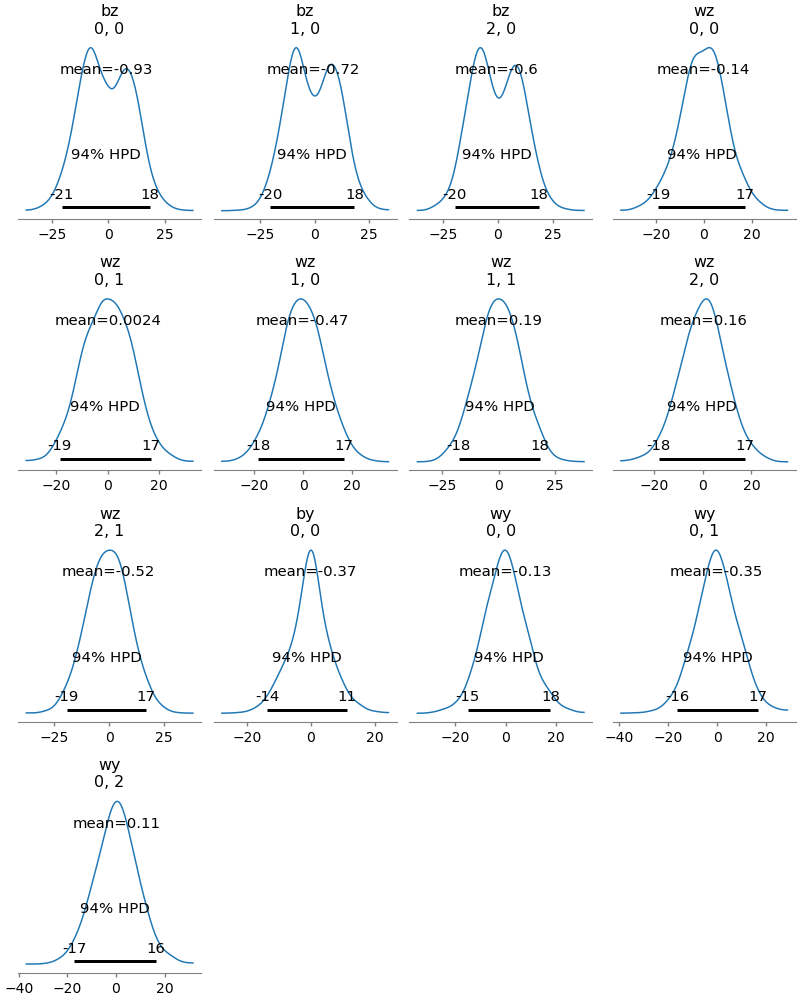

In [63]:
with b100:
    pm.plot_posterior(trace_m2, figsize=(8, 10), var_names=['bz', 'wz', 'by','wy'], textsize=10);

#### Posterior Predictiva

In [64]:
with b100:
    pm.set_data({"x": x_test100})
    posterior_predictive = pm.sample_posterior_predictive(trace_m2, samples=50, var_names=["X", "Y_obs"])

C:\Users\spun\miniconda3\lib\site-packages\pymc3\sampling.py:1246: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(
100%|█████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 133.96it/s]


<IPython.core.display.Javascript object>


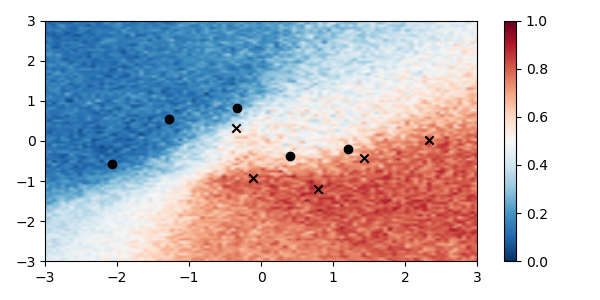

In [65]:
fig, ax = plt.subplots(figsize=(6, 3), tight_layout=True)
cmap = ax.pcolormesh(x1100, x2100, np.mean(posterior_predictive['Y_obs'], axis=0).reshape(len(x1100), len(x2100)), 
                     cmap=plt.cm.RdBu_r, shading='gouraud', vmin=0, vmax=1)
plt.colorbar(cmap, ax=ax)
ax.scatter(x[y==0, 0], x[y==0, 1], c='k', marker='o')
ax.scatter(x[y==1, 0], x[y==1, 1], c='k', marker='x')

### Modelo 3 (100 samples)

#### Posterior Parámetros

C:\Users\spun\miniconda3\lib\site-packages\arviz\plots\plot_utils.py:624: SyntaxWarning: rcParams['plot.max_subplots'] (40) is smaller than the number of variables to plot (41) in plot_posterior, generating only 40 plots
  warnings.warn(


<IPython.core.display.Javascript object>


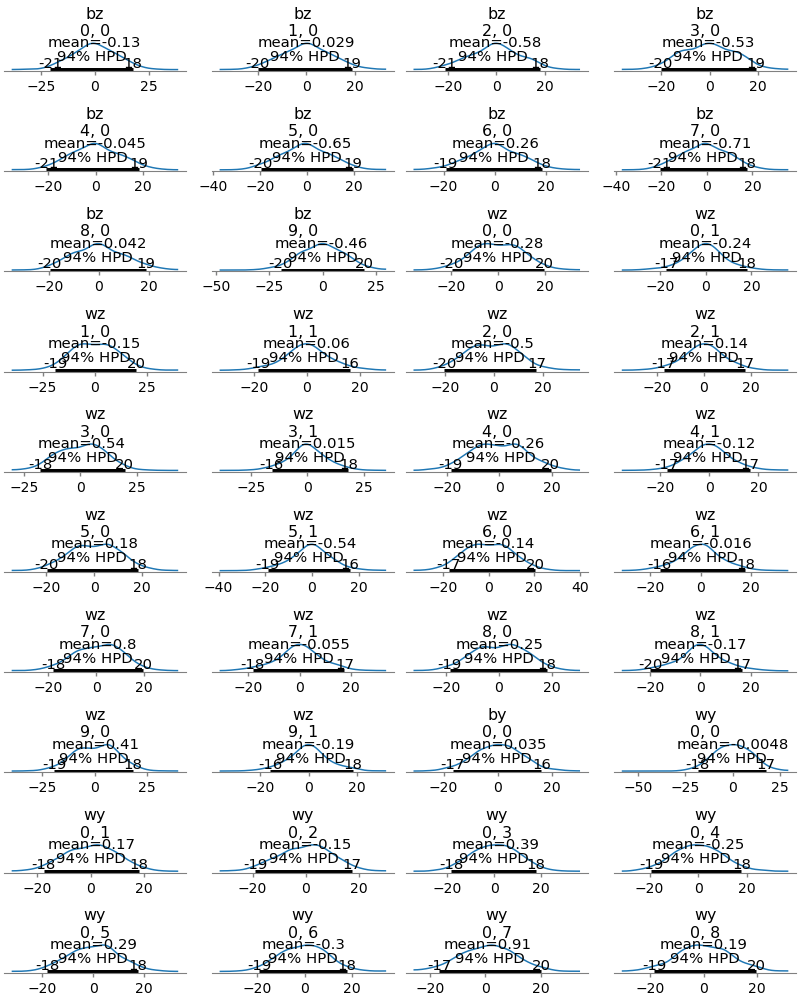

In [162]:
with c100:
    pm.plot_posterior(trace_m3, figsize=(8, 10), var_names=['bz', 'wz', 'by','wy'], textsize=10);

#### Posterior Predictiva

In [163]:
with c100:
    pm.set_data({"x": x_test100})
    posterior_predictive = pm.sample_posterior_predictive(trace_m3, samples=50, var_names=["X", "Y_obs"])

C:\Users\spun\miniconda3\lib\site-packages\pymc3\sampling.py:1246: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(
100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 48.93it/s]


<IPython.core.display.Javascript object>


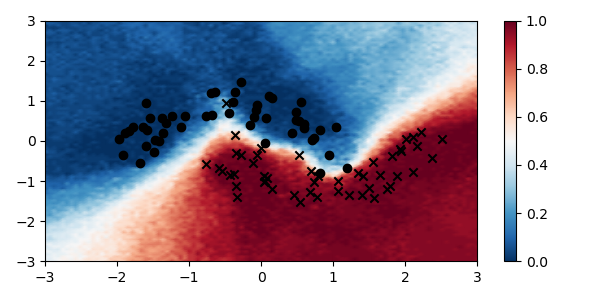

In [164]:
fig, ax = plt.subplots(figsize=(6, 3), tight_layout=True)
cmap = ax.pcolormesh(x1100, x2100, np.mean(posterior_predictive['Y_obs'], axis=0).reshape(len(x1100), len(x2100)), 
                     cmap=plt.cm.RdBu_r, shading='gouraud', vmin=0, vmax=1)
plt.colorbar(cmap, ax=ax)
ax.scatter(x[y==0, 0], x[y==0, 1], c='k', marker='o')
ax.scatter(x[y==1, 0], x[y==1, 1], c='k', marker='x')

### Modelo 4 (10 samples)

In [167]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import make_moons

x, y = make_moons(n_samples=10, # Varie este parámetro
                  shuffle=True, noise=0.2, random_state=123456)
x = (x - np.mean(x, keepdims=True))/np.std(x, keepdims=True)

x110, x210 = np.meshgrid(np.linspace(-3, 3, 100), 
                     np.linspace(-3, 3, 100))
x_test10 = np.vstack([x110.ravel(), x210.ravel()]).T

#### Posterior Parámetros

<IPython.core.display.Javascript object>


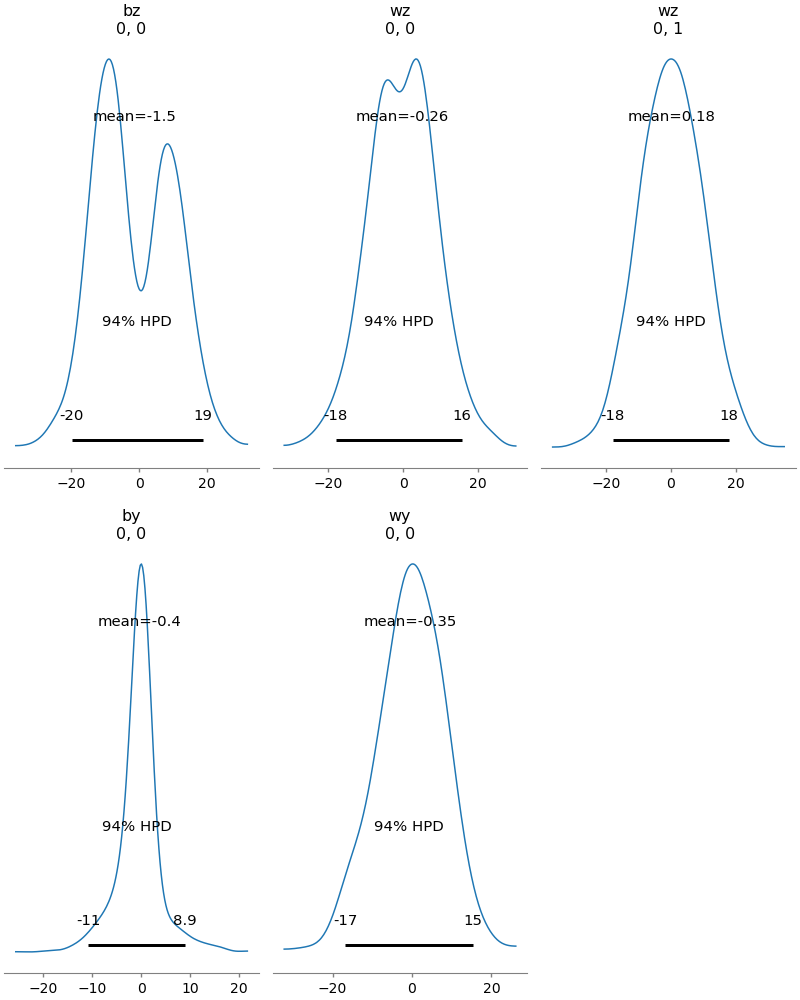

In [134]:
with a10:
    pm.plot_posterior(trace_m4, figsize=(8, 10), var_names=['bz', 'wz', 'by','wy'], textsize=10);

#### Posterior Predictiva

In [135]:
with a10:
    pm.set_data({"x": x_test10})
    posterior_predictive = pm.sample_posterior_predictive(trace_m4, samples=50, var_names=["X", "Y_obs"])

C:\Users\spun\miniconda3\lib\site-packages\pymc3\sampling.py:1246: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(
100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 69.17it/s]


<IPython.core.display.Javascript object>


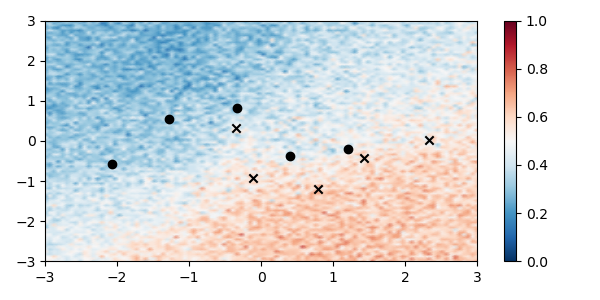

In [136]:
fig, ax = plt.subplots(figsize=(6, 3), tight_layout=True)
cmap = ax.pcolormesh(x110, x210, np.mean(posterior_predictive['Y_obs'], axis=0).reshape(len(x110), len(x210)), 
                     cmap=plt.cm.RdBu_r, shading='gouraud', vmin=0, vmax=1)
plt.colorbar(cmap, ax=ax)
ax.scatter(x[y==0, 0], x[y==0, 1], c='k', marker='o')
ax.scatter(x[y==1, 0], x[y==1, 1], c='k', marker='x')

### Modelo 5 (10 samples)

#### Posterior Parámetros

<IPython.core.display.Javascript object>


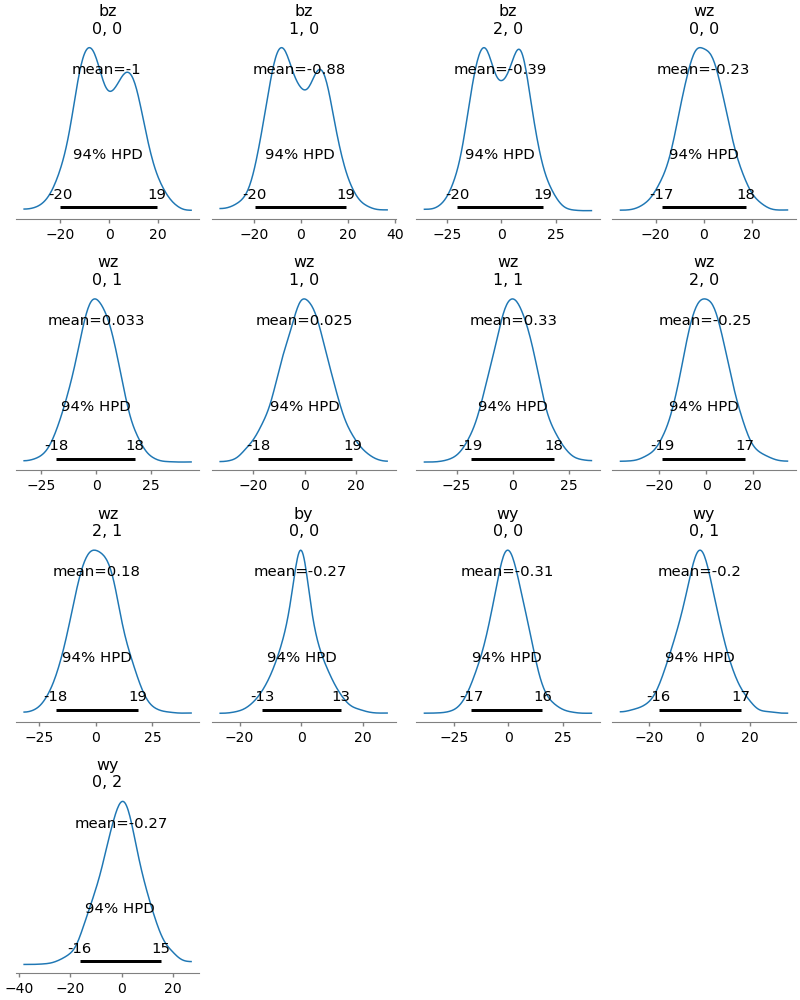

In [137]:
with b10:
    pm.plot_posterior(trace_m5, figsize=(8, 10), var_names=['bz', 'wz', 'by','wy'], textsize=10);

#### Posterior Predictiva

In [138]:
with b10:
    pm.set_data({"x": x_test10})
    posterior_predictive = pm.sample_posterior_predictive(trace_m5, samples=50, var_names=["X", "Y_obs"])

C:\Users\spun\miniconda3\lib\site-packages\pymc3\sampling.py:1246: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(
100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 56.31it/s]


<IPython.core.display.Javascript object>


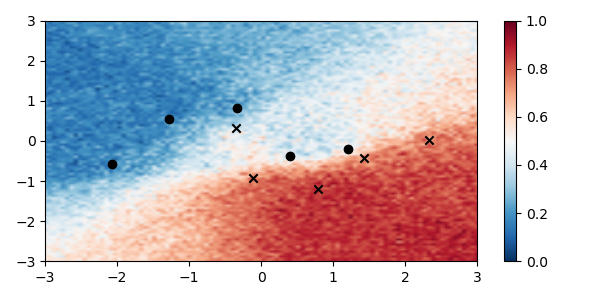

In [139]:
fig, ax = plt.subplots(figsize=(6, 3), tight_layout=True)
cmap = ax.pcolormesh(x110, x210, np.mean(posterior_predictive['Y_obs'], axis=0).reshape(len(x110), len(x210)), 
                     cmap=plt.cm.RdBu_r, shading='gouraud', vmin=0, vmax=1)
plt.colorbar(cmap, ax=ax)
ax.scatter(x[y==0, 0], x[y==0, 1], c='k', marker='o')
ax.scatter(x[y==1, 0], x[y==1, 1], c='k', marker='x')

### Modelo 6 (10 samples)

#### Posterior Parámetros

C:\Users\spun\miniconda3\lib\site-packages\arviz\plots\plot_utils.py:624: SyntaxWarning: rcParams['plot.max_subplots'] (40) is smaller than the number of variables to plot (41) in plot_posterior, generating only 40 plots
  warnings.warn(


<IPython.core.display.Javascript object>


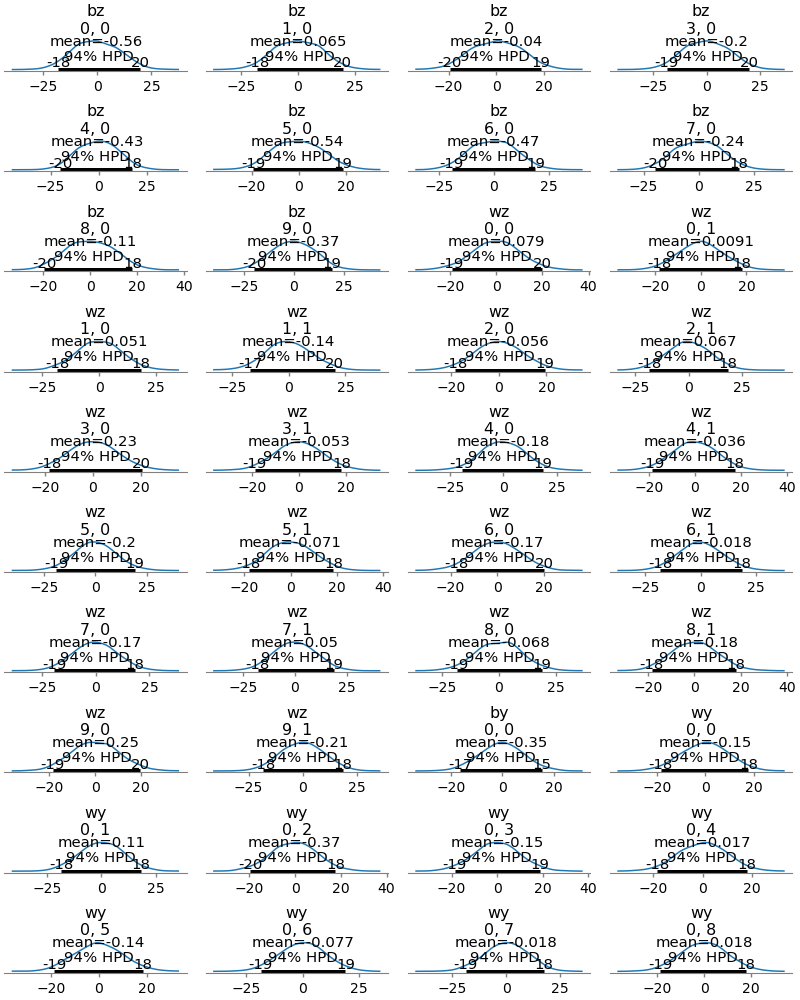

In [140]:
with c10:
    pm.plot_posterior(trace_m6, figsize=(8, 10), var_names=['bz', 'wz', 'by','wy'], textsize=10);

#### Posterior Predictiva

In [141]:
with c10:
    pm.set_data({"x": x_test10})
    posterior_predictive = pm.sample_posterior_predictive(trace_m6, samples=50, var_names=["X", "Y_obs"])

C:\Users\spun\miniconda3\lib\site-packages\pymc3\sampling.py:1246: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(
100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 44.84it/s]


<IPython.core.display.Javascript object>


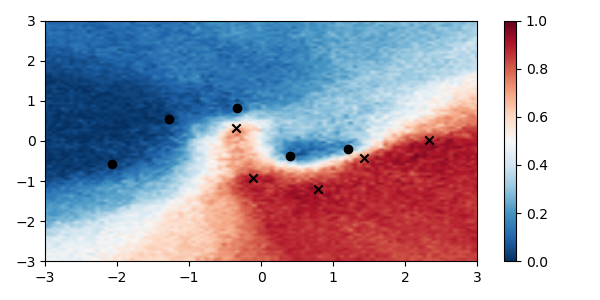

In [142]:
fig, ax = plt.subplots(figsize=(6, 3), tight_layout=True)
cmap = ax.pcolormesh(x110, x210, np.mean(posterior_predictive['Y_obs'], axis=0).reshape(len(x110), len(x210)), 
                     cmap=plt.cm.RdBu_r, shading='gouraud', vmin=0, vmax=1)
plt.colorbar(cmap, ax=ax)
ax.scatter(x[y==0, 0], x[y==0, 1], c='k', marker='o')
ax.scatter(x[y==1, 0], x[y==1, 1], c='k', marker='x')

## Observaciones